In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
import ulmo
import datetime as dt
from datetime import datetime
from shapely.geometry import Point
import metloom
from metloom.pointdata import CDECPointData
from metloom.pointdata import SnotelPointData
from metloom.variables import CdecStationVariables
import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd
import sklearn
from sklearn.cluster import KMeans

In [2]:
wstates = gpd.read_file('../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')

wstates_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

In [3]:
cdec_depth = pickle.load(open('../data/cdec/cdec_april1_depth.pkl', 'rb'))
cdec_locations = pickle.load(open('../data/cdec/cdec_nan_locations.pkl', 'rb'))

snotel_depth = pickle.load(open('../data/snotel/snotel_april1_anom.pkl', 'rb'))
snotel_locations = pickle.load(open('../data/snotel/western_snotel_nan.pkl','rb'))

## Combine the Snotel and CDEC dataframes:

In [4]:
snotel_depth.index = pd.to_datetime(snotel_depth.index).date
cdec_depth.index = pd.to_datetime(cdec_depth.index).date

In [5]:
combined_april1_anom = pd.merge(snotel_depth, cdec_depth, how='inner', left_index=True, right_index=True)

In [6]:
combined_april1_anom.head()

301_CA_SNTL  356_CA_SNTL  1051_CA_SNTL  1067_CA_SNTL  977_CA_SNTL  \
2005-04-01          1.6         35.4         21.15     37.947368    -1.833333   
2006-04-01         18.6         35.4         53.15     58.947368    11.166667   
2007-04-01        -13.4        -29.6        -35.85    -33.052632    -1.833333   
2008-04-01          6.6         -2.6        -20.85    -21.052632     0.166667   
2009-04-01          0.6         -6.6         -8.85     -5.052632    -1.833333   

            462_CA_SNTL  463_CA_SNTL  473_CA_SNTL  1049_CA_SNTL  508_CA_SNTL  \
2005-04-01    31.478261    40.095238     8.826087          31.1        20.28   
2006-04-01    58.478261    49.095238    19.826087          54.1        38.28   
2007-04-01   -39.521739   -41.904762   -10.173913         -32.9       -24.72   
2008-04-01   -16.521739   -11.904762    -0.173913         -18.9        -4.72   
2009-04-01   -11.521739   -12.904762   -10.173913          -4.9        -7.72   

            ...  849_NV_SNTL        DAN        HOR        INN        TK2  \
2005-04-01  ...        45.12  40.526316  23.631579  17.736842  18.578947   
2006-04-01  ...        21.12  55.526316  44.631579  13.736842  11.578947   
2007-04-01  ...       -16.88 -43.473684 -27.368421 -11.263158 -22.421053   
2008-04-01  ...         0.12 -15.473684 -13.368421   6.736842  -3.421053   
2009-04-01  ...        12.12 -10.473684 -12.368421  -2.263158 -10.421053   

                  MRL        RCK        BLK        IDC        SDW  
2005-04-01  23.894737  20.421053  33.631579  15.631579  36.052632  
2006-04-01  29.894737  32.421053  30.631579   1.631579  60.052632  
2007-04-01 -36.105263 -35.578947 -30.368421 -29.368421 -29.947368  
2008-04-01  -7.105263  -6.578947  -4.368421  -7.368421  -9.947368  
2009-04-01 -22.105263 -25.578947  -8.368421 -17.368421 -16.947368  

[5 rows x 492 columns]

In [7]:
snotel_locations.head()

name network  elevation_m                     geometry  \
code                                                                            
301_CA_SNTL        Adin Mtn  SNOTEL  1886.712036  POINT (-120.79192 41.23583)   
356_CA_SNTL      Blue Lakes  SNOTEL  2458.821533  POINT (-119.92437 38.60800)   
1051_CA_SNTL  Burnside Lake  SNOTEL  2477.719238  POINT (-119.89420 38.71943)   
1067_CA_SNTL    Carson Pass  SNOTEL  2548.127930  POINT (-120.00220 38.69270)   
977_CA_SNTL    Crowder Flat  SNOTEL  1575.816040  POINT (-120.75202 41.89318)   

                    U1  
code                    
301_CA_SNTL  -0.051691  
356_CA_SNTL  -0.109090  
1051_CA_SNTL -0.111909  
1067_CA_SNTL -0.112912  
977_CA_SNTL  -0.011510

In [8]:
# Reformat station geodataframes so I can combine them:

# snotel_locations = snotel_locations.drop(columns={'site_property', 'code', 'GEO_ID', 'STATE', 'NAME', 'LSAD', 'CENSUSAREA'})
cdec_locations = cdec_locations.rename(columns={'id':'code','datasource':'network'})
cdec_locations['elevation_m'] = cdec_locations.geometry.z * 0.3048
cdec_locations = cdec_locations.set_index('code')
cdec_locations = cdec_locations.set_crs('epsg:4326')

In [9]:
station_locations = pd.concat([snotel_locations, cdec_locations])

In [10]:
station_locations

name network  elevation_m  \
code                                                   
301_CA_SNTL            Adin Mtn  SNOTEL  1886.712036   
356_CA_SNTL          Blue Lakes  SNOTEL  2458.821533   
1051_CA_SNTL      Burnside Lake  SNOTEL  2477.719238   
1067_CA_SNTL        Carson Pass  SNOTEL  2548.127930   
977_CA_SNTL        Crowder Flat  SNOTEL  1575.816040   
...                         ...     ...          ...   
MRL               MARLETTE LAKE    CDEC  2438.400000   
RCK            ROCK CREEK LAKES    CDEC  2956.560000   
BLK                  BLUE LAKES    CDEC  2438.400000   
IDC           INDEPENDENCE CAMP    CDEC  2133.600000   
SDW               SUMMIT MEADOW    CDEC  2838.602400   

                                              geometry        U1  
code                                                              
301_CA_SNTL                POINT (-120.79192 41.23583) -0.051691  
356_CA_SNTL                POINT (-119.92437 38.60800) -0.109090  
1051_CA_SNTL               POINT (-119.89420 38.71943) -0.111909  
1067_CA_SNTL               POINT (-120.00220 38.69270) -0.112912  
977_CA_SNTL                POINT (-120.75202 41.89318) -0.011510  
...                                                ...       ...  
MRL           POINT Z (-119.90500 39.17300 8000.00000)       NaN  
RCK           POINT Z (-118.73502 37.45728 9700.00000)       NaN  
BLK           POINT Z (-119.93100 38.61300 8000.00000)       NaN  
IDC           POINT Z (-120.29855 39.45259 7000.00000)       NaN  
SDW           POINT Z (-119.53560 38.39750 9313.00000)       NaN  

[492 rows x 5 columns]

## Perform SVD analysis:

In [11]:
# Convert to an array for use in the svd function
snotel_depth_array = snotel_depth.to_numpy()
combined_depth_array = combined_april1_anom.to_numpy()

In [12]:
# Perform the SVD

# Repeat the snotel analysis for comparison
Us, Ss, Vs = svd(snotel_depth_array.T,full_matrices=False)

# do the analysis on the combined snotel and cdec data
Uc, Sc, Vc = svd(combined_depth_array.T,full_matrices=False)

In [13]:
# SVD Variance Explained, divide S values by the sum of all S
var_exp = Sc / np.sum(Sc)

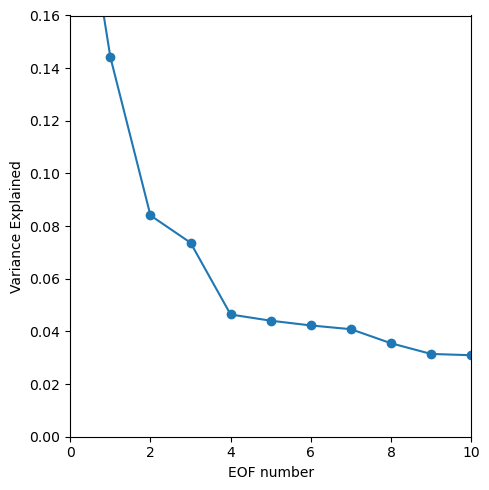

In [15]:
plt.figure(figsize=(5,5))
plt.plot(var_exp,'-o')
plt.xlabel('EOF number')
plt.ylabel('Variance Explained')
#plt.title('SVD Variance Explained')
plt.ylim([0,0.16])
plt.xlim([0,10])
plt.tight_layout()
#plt.savefig('../../../QualifyingExam/eof_varianceexplained.jpeg');

#### The first four EOFs explain most of the variance:

In [16]:
# the first 10:
print(var_exp[0:10])

# sum of the first 10
print('Percent of overall variance expplained by the top 10 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:10]),1)))

[0.23991091 0.14418894 0.08406191 0.07369266 0.04642795 0.04407407
 0.04226837 0.04084551 0.03550985 0.03144596]
Percent of overall variance expplained by the top 10 patterns = 78.2%


In [17]:
# the first 10:
print(var_exp[0:4])

# sum of the first 10
print('Percent of overall variance expplained by the top 4 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:4]),1)))

[0.23991091 0.14418894 0.08406191 0.07369266]
Percent of overall variance expplained by the top 4 patterns = 54.2%


### Plot the results of the Combined (Snotel and CDEC) next to just the Snotel:

Text(510.3244949494949, 0.5, 'weight')

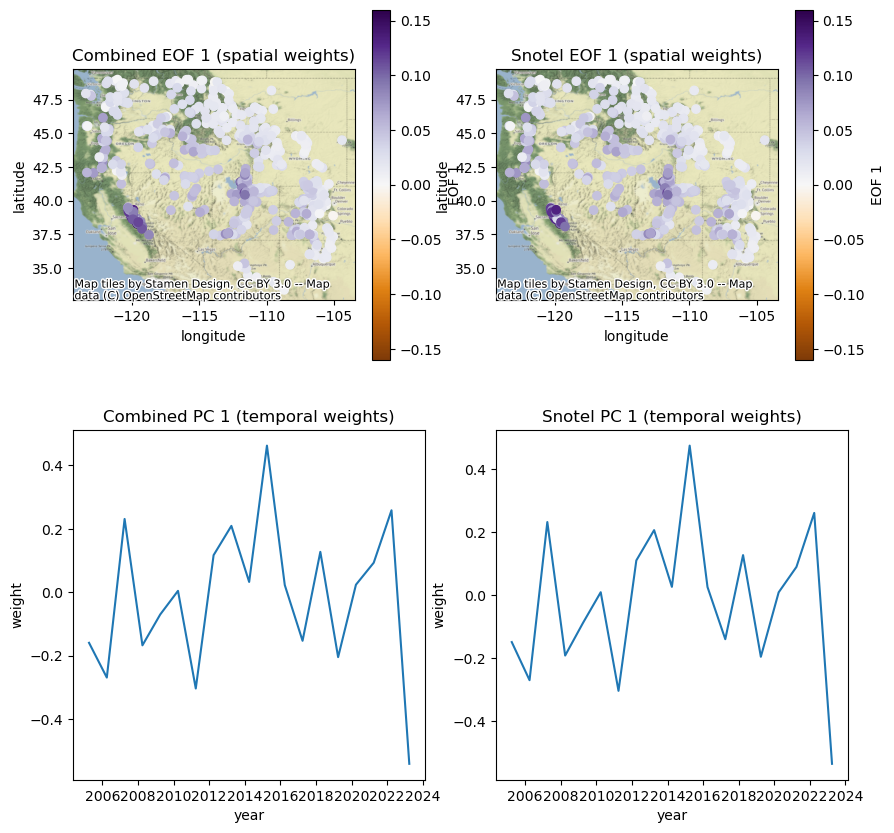

In [18]:
# first index for both U and V
i = 0
station_locations[f'U{i}'] = Uc[:,i]

# plot first EOF (U)
fig, ax = plt.subplots(2,2, figsize=(10,10))
station_locations.plot(ax=ax[0,0], column=-1*Uc[:,i], legend=True, cmap='PuOr', legend_kwds={'label': "EOF 1",'orientation': "vertical"}, vmin=-0.16, vmax=0.16)
ctx.add_basemap(ax=ax[0,0], crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
wstates.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('Combined EOF 1 (spatial weights)');
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')

#Plot first PC (V)
#plt.figure(figsize=(10,3))
ax[1,0].plot(combined_april1_anom.index,Vc[i,:]);
ax[1,0].set_title('Combined PC 1 (temporal weights)');
ax[1,0].set_xlabel('year')
ax[1,0].set_ylabel('weight')

# plot first EOF (U)
snotel_locations[f'U{i}'] = Us[:,i]

snotel_locations.plot(ax=ax[0,1], column=-1*Us[:,i], legend=True, cmap='PuOr', legend_kwds={'label': "EOF 1",'orientation': "vertical"}, vmin=-0.16, vmax=0.16)
ctx.add_basemap(ax=ax[0,1], crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
wstates.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Snotel EOF 1 (spatial weights)');
ax[0,1].set_xlabel('longitude')
ax[0,1].set_ylabel('latitude')

#Plot first PC (V)
#plt.figure(figsize=(10,3))
ax[1,1].plot(snotel_depth.index,Vs[i,:]);
ax[1,1].set_title('Snotel PC 1 (temporal weights)');
ax[1,1].set_xlabel('year')
ax[1,1].set_ylabel('weight')

### Zoom into the Central Sierra:

(36.0, 40.0)

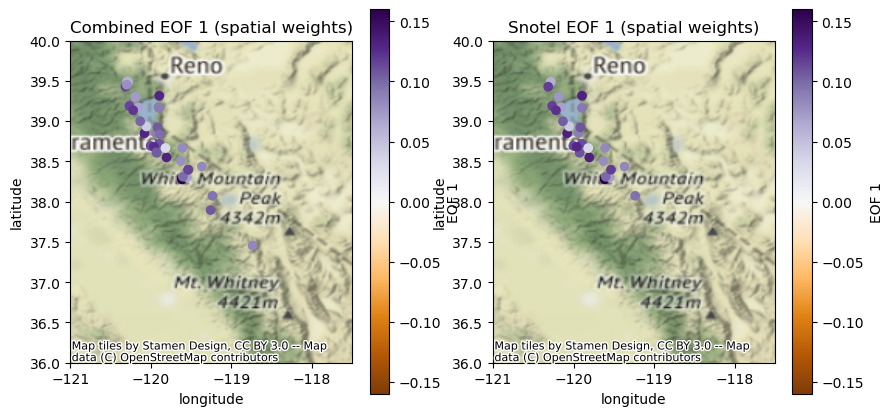

In [19]:
i = 0
#station_locations[f'U{i}'] = Uc[:,i]
# plot first EOF (U)
fig, ax = plt.subplots(1,2,figsize=(10,5))

station_locations.plot(ax=ax[0], column=-1*Uc[:,i], legend=True, cmap='PuOr', legend_kwds={'label': "EOF 1",'orientation': "vertical"}, vmin=-0.16, vmax=0.16)
ctx.add_basemap(ax=ax[0], crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
wstates.plot(ax=ax[0], facecolor='none', edgecolor='k')
ax[0].set_title('Combined EOF 1 (spatial weights)');
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].set_xlim(-121,-117.5)
ax[0].set_ylim(36,40)

snotel_locations.plot(ax=ax[1], column=-1*Us[:,i], legend=True, cmap='PuOr', legend_kwds={'label': "EOF 1",'orientation': "vertical"}, vmin=-0.16, vmax=0.16)
ctx.add_basemap(ax=ax[1], crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
wstates.plot(ax=ax[1], facecolor='none', edgecolor='k')
ax[1].set_title('Snotel EOF 1 (spatial weights)');
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')
ax[1].set_xlim(-121,-117.5)
ax[1].set_ylim(36,40)

### Plot the first four spatial and temporal weights:

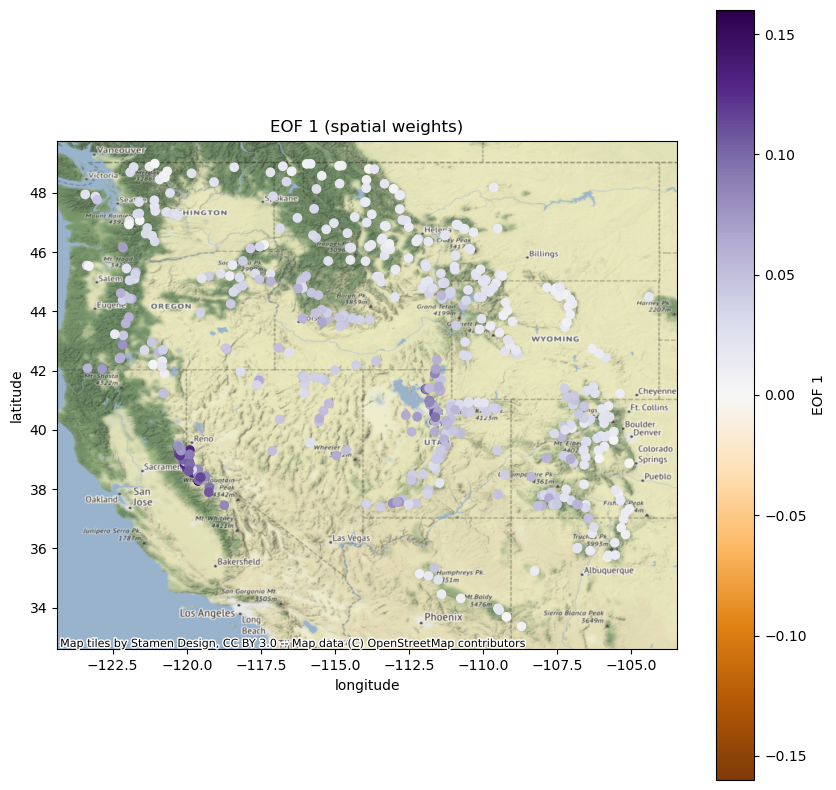

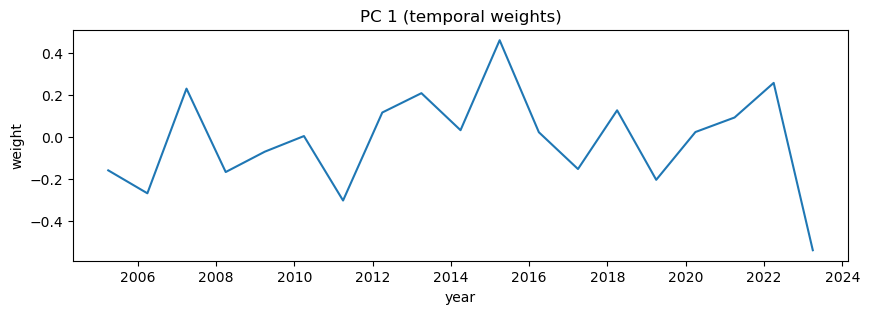

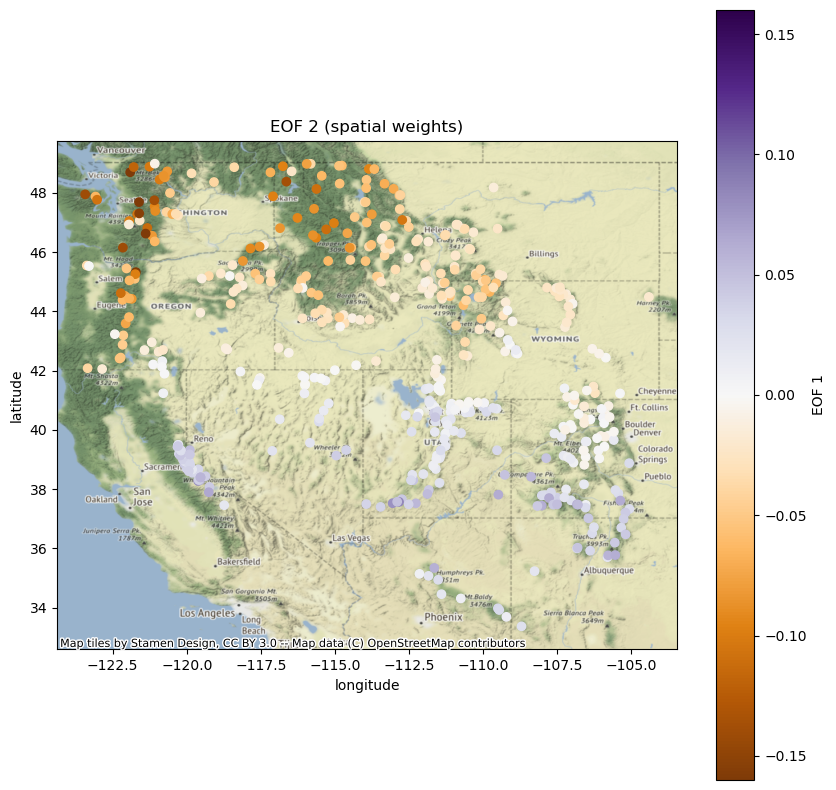

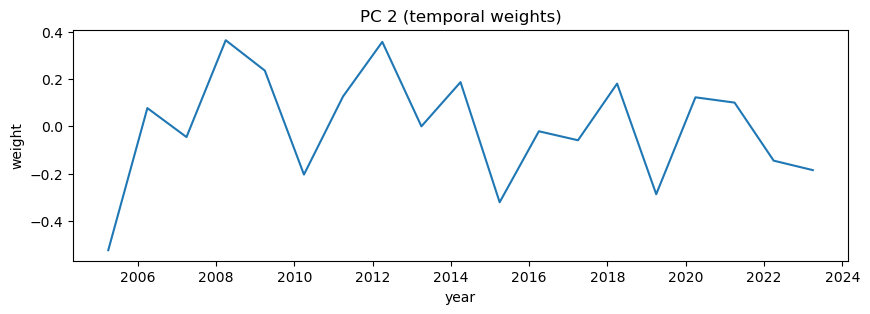

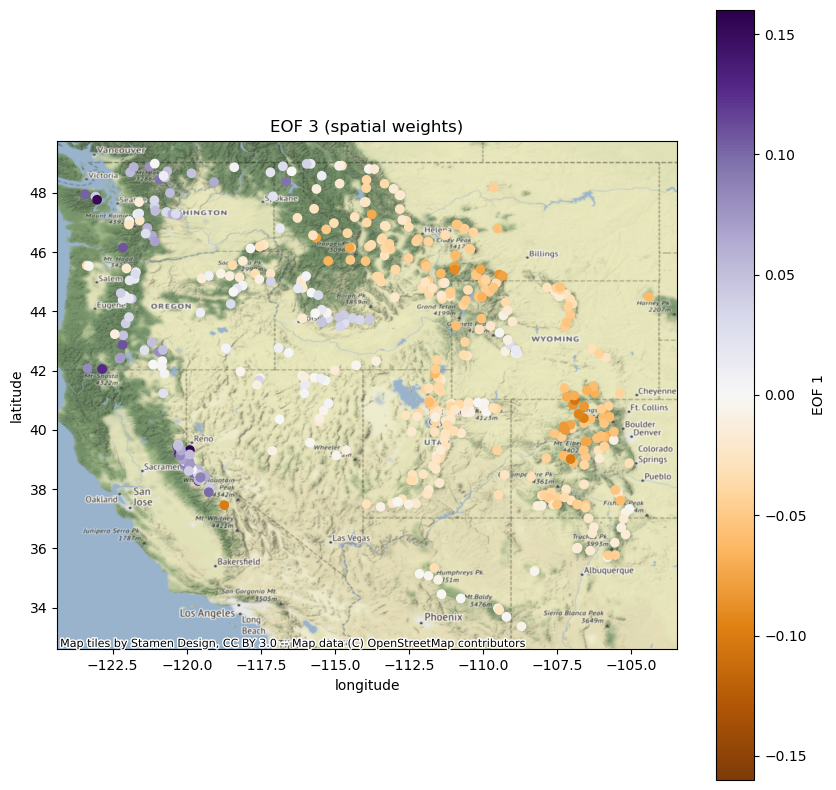

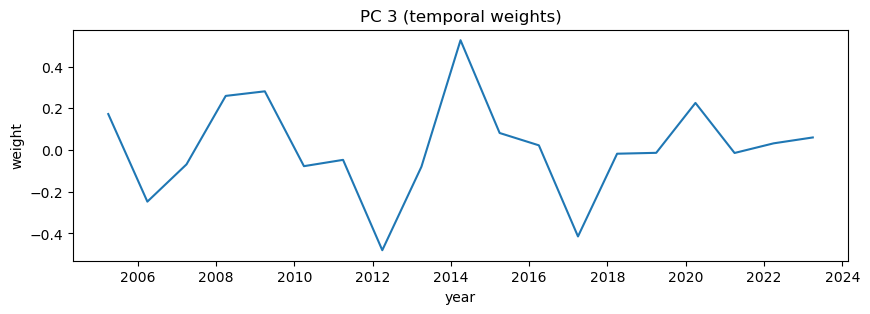

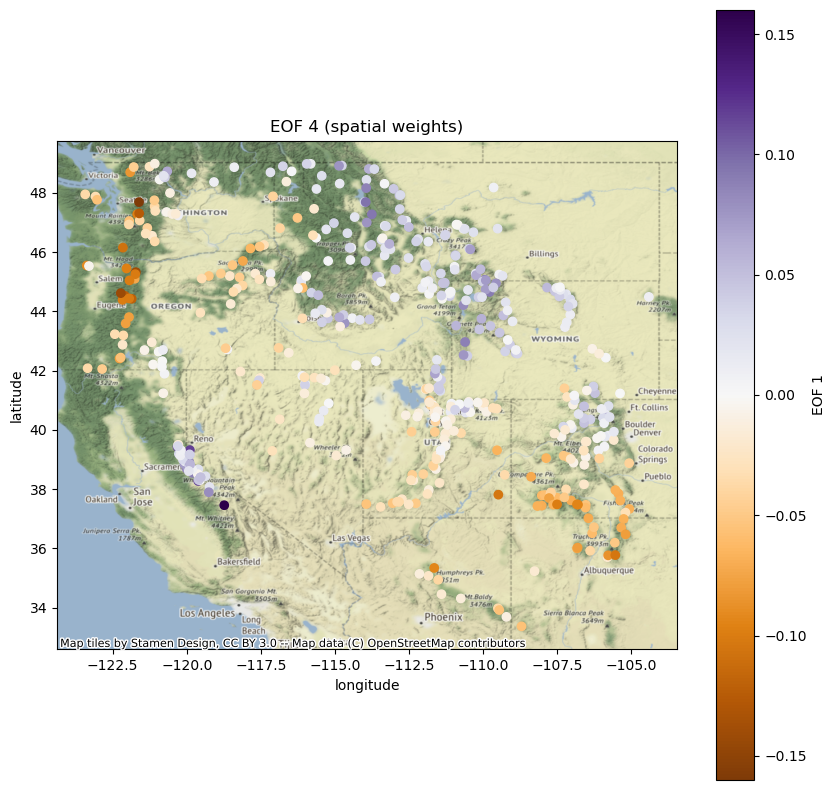

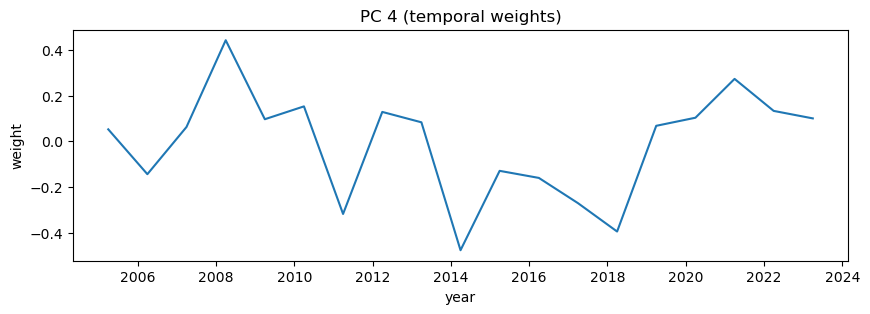

In [20]:
# first four indexes for both U and V

for i in range(4):

    #station_locations[f'U{i}'] = Uc[:,i]
    # plot first EOF (U)
    fig, ax = plt.subplots(figsize=(10,10))
    station_locations.plot(ax=ax, column=-1*Uc[:,i], legend=True, cmap='PuOr', legend_kwds={'label': "EOF 1",'orientation': "vertical"}, vmin=-0.16, vmax=0.16)
    ctx.add_basemap(ax=ax, crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
    wstates.plot(ax=ax, facecolor='none', edgecolor='k')
    plt.title(f'EOF {i+1} (spatial weights)');
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    #Plot first PC (V)
    plt.figure(figsize=(10,3))
    plt.plot(combined_april1_anom.index,Vc[i,:]);
    plt.title(f'PC {i+1} (temporal weights)');
    plt.xlabel('year')
    plt.ylabel('weight')

In [14]:
colorado = wstates[wstates['NAME'] == 'Colorado']

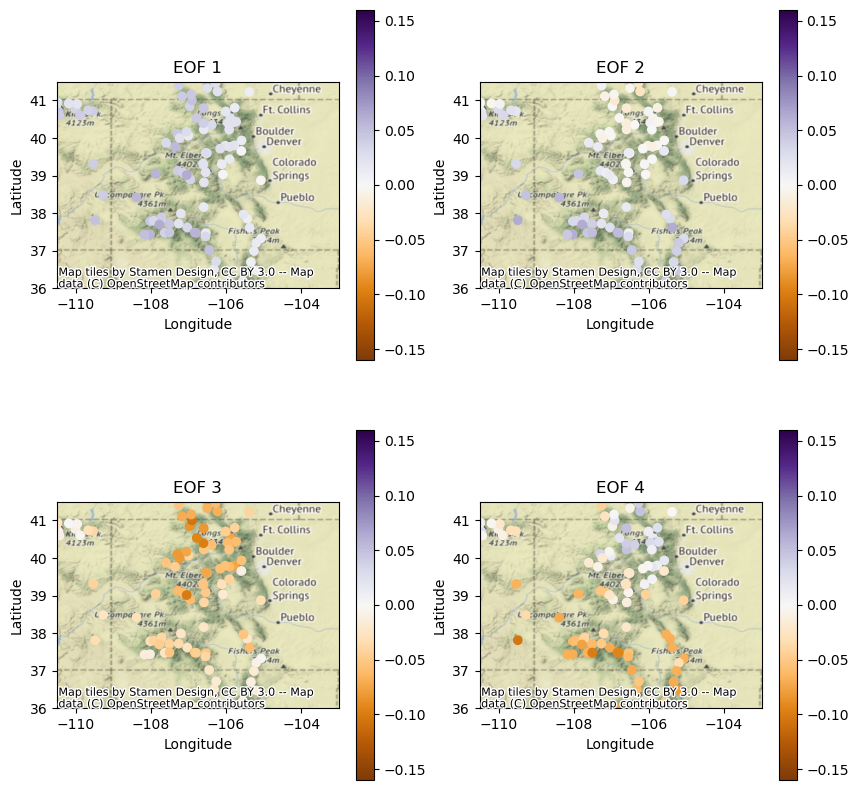

In [22]:
f, ax = plt.subplots(2,2,figsize=(10,10))
i = 0
for row in range(2):
    for column in range(2):     
        station_locations.plot(ax=ax[row,column], column=-1*Uc[:,i], legend=True, cmap='PuOr', vmin=-0.16, vmax=0.16)
        ctx.add_basemap(ax=ax[row,column], crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
        ax[row,column].set_xlim(-110.5,-103)
        ax[row,column].set_ylim(36,41.5)
        ax[row,column].set_title('EOF {}'.format(i+1))
        ax[row,column].set_xlabel('Longitude')
        ax[row,column].set_ylabel('Latitude')
        i+=1

## Perform the K-means Clustering analysis:

Determine best parameters for:  
* init
* n_init
* cluster number

In [15]:
pearsons_cc = np.corrcoef(combined_depth_array.T)

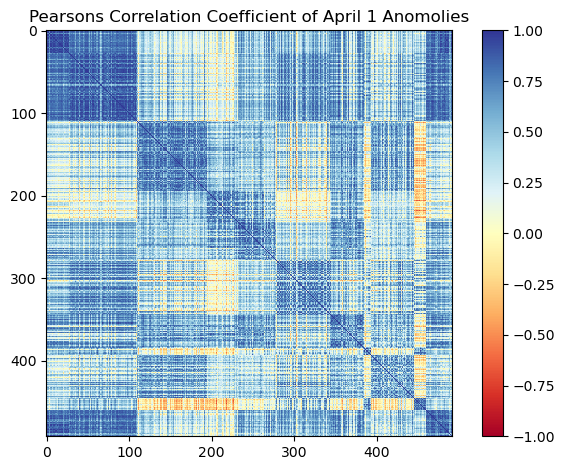

In [24]:
# code from https://www.kaggle.com/code/ignacioalorre/clustering-features-based-on-correlation-and-tags

plt.figure()
plt.imshow(pearsons_cc, interpolation='nearest', cmap ='RdYlBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Pearsons Correlation Coefficient of April 1 Anomolies')
plt.tight_layout()

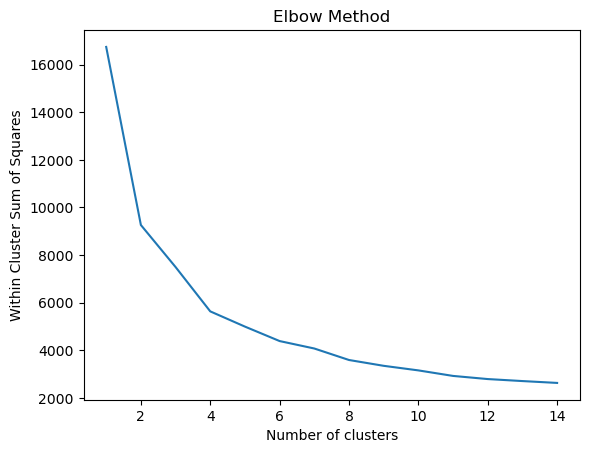

In [25]:
# code from https://www.kaggle.com/code/ignacioalorre/clustering-features-based-on-correlation-and-tags
# Determine optimun number of clusters for kmeans
wcss = []
max_num_clusters = 15
for i in range(1, max_num_clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init='auto', random_state=0)
    kmeans.fit(pearsons_cc)
    wcss.append(kmeans.inertia_)
fig, ax = plt.subplots()    
plt.plot(range(1, max_num_clusters), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

## Interpretation:  
The elbow method doesn't seem very useful here - there's no elbow! 

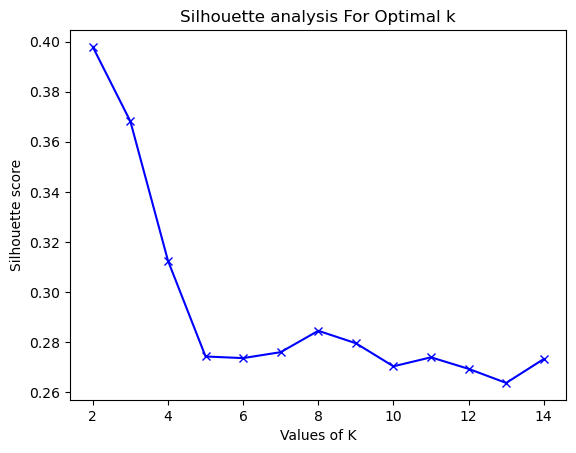

<Figure size 640x480 with 0 Axes>

In [26]:
# code from https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
#import sklearn.metrics.silhouette_score as silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)
    kmeans.fit(pearsons_cc)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(sklearn.metrics.silhouette_score(pearsons_cc, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()
plt.tight_layout()
#plt.savefig('../../../QualifyingExam/avg_silhouette.jpeg')

In [ ]:
# # need to install yellowbrick before running this

# from yellowbrick.cluster import SilhouetteVisualizer
  
# fig, ax = plt.subplots(3, 3, figsize=(15,15))
# for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
#     '''
#     Create KMeans instances for different number of clusters
#     '''
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
#     q, mod = divmod(i, 3)
#     '''
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
#     '''
#     visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit(pearsons_cc) 
#     ax[q-1][mod].set_title('{} Clusters'.format(i))

# #plt.savefig('../../../QualifyingExam/silhouettevisualization.jpeg')

In [16]:
# Continued code from https://www.kaggle.com/code/ignacioalorre/clustering-features-based-on-correlation-and-tags

# Using kmeans to cluster the features based on their correlation
n_clusters_kmeans = 6
kmeans = KMeans(n_clusters = n_clusters_kmeans, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
pearsons_cc_labels = kmeans.fit_predict(pearsons_cc)
feat_names = combined_april1_anom.columns
# Preparing a dataframe to collect some cluster stats
pearsons_cc_clust_df = pd.DataFrame(np.c_[feat_names, pearsons_cc_labels])
pearsons_cc_clust_df.columns = ["feature", "cluster"]
pearsons_cc_clust_df['feat_list'] = pearsons_cc_clust_df.groupby(["cluster"]).transform(lambda x: ', '.join(x))
pearsons_cc_clust_df = pearsons_cc_clust_df.groupby(["cluster", "feat_list"]).size().reset_index(name = 'feat_count')
pearsons_cc_clust_df

cluster                                          feat_list  feat_count
0        0  303_CO_SNTL, 430_CO_SNTL, 936_CO_SNTL, 1057_CO...          29
1        1  916_MT_SNTL, 313_MT_SNTL, 315_MT_SNTL, 318_MT_...          99
2        2  301_CA_SNTL, 356_CA_SNTL, 1051_CA_SNTL, 1067_C...         157
3        3  347_MT_SNTL, 609_MT_SNTL, 813_MT_SNTL, 858_MT_...          63
4        4  575_CA_SNTL, 778_CA_SNTL, 907_UT_SNTL, 339_UT_...          58
5        5  307_MT_SNTL, 311_MT_SNTL, 414_MT_SNTL, 436_MT_...          86

In [17]:
# Continued code from https://www.kaggle.com/code/ignacioalorre/clustering-features-based-on-correlation-and-tags

corr_node_dist = kmeans.transform(pearsons_cc)
corr_clust_dist = np.c_[feat_names, np.round(corr_node_dist.min(axis=1),3), np.round(corr_node_dist.min(axis=1)/np.max(corr_node_dist.min(axis=1)),3), pearsons_cc_labels]
corr_clust_dist_df = pd.DataFrame(corr_clust_dist)
corr_clust_dist_df.columns = ['feature', 'dist_corr', 'dist_corr_norm', 'cluster_corr']
corr_clust_dist_df

feature dist_corr dist_corr_norm cluster_corr
0     301_CA_SNTL     1.737          0.255            2
1     356_CA_SNTL     1.838           0.27            2
2    1051_CA_SNTL     2.499          0.367            2
3    1067_CA_SNTL     2.191          0.322            2
4     977_CA_SNTL     3.912          0.575            2
..            ...       ...            ...          ...
487           MRL     2.467          0.363            2
488           RCK     4.198          0.617            2
489           BLK     1.874          0.275            2
490           IDC     3.684          0.541            4
491           SDW     2.768          0.407            2

[492 rows x 4 columns]

In [18]:
station_locations['cluster_corr'] = corr_clust_dist_df['cluster_corr'].values

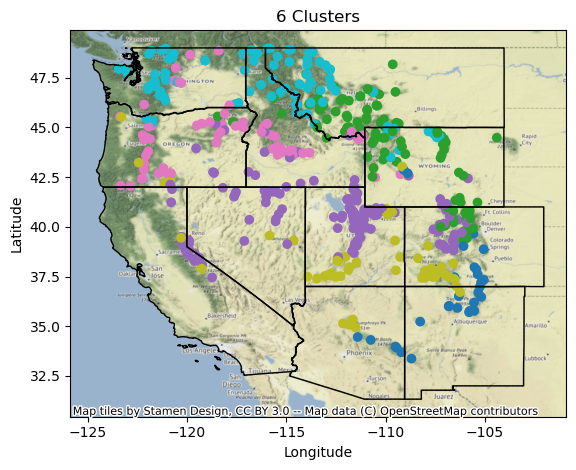

In [30]:
fig, ax = plt.subplots()

station_locations.plot(ax=ax, column='cluster_corr')
wstates.to_crs('epsg:4326').plot(ax=ax, facecolor='none')
ctx.add_basemap(ax=ax, crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
ax.set_title('6 Clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()

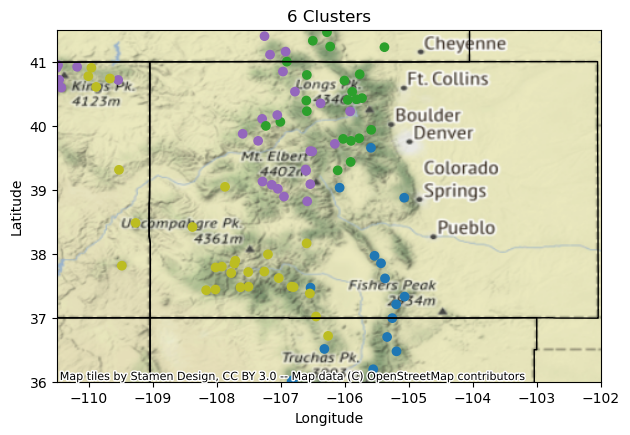

In [31]:
fig, ax = plt.subplots()

station_locations.plot(ax=ax, column='cluster_corr')
wstates.to_crs('epsg:4326').plot(ax=ax, facecolor='none')
ctx.add_basemap(ax=ax, crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
ax.set_title('6 Clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-110.5,-102)
ax.set_ylim(36,41.5)
plt.tight_layout()
#plt.savefig('../../../QualifyingExam/map_6clusters_CO.jpeg')

In [19]:
# Using kmeans to cluster the features based on their correlation
def cluster(n_clusters_kmeans, correlation_df):

    kmeans = KMeans(n_clusters = n_clusters_kmeans, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    pearsons_cc_labels = kmeans.fit_predict(correlation_df)
    feat_names = combined_april1_anom.columns
    # Preparing a dataframe to collect some cluster stats
    pearsons_cc_clust_df = pd.DataFrame(np.c_[feat_names, pearsons_cc_labels])
    pearsons_cc_clust_df.columns = ["feature", "cluster"]
    pearsons_cc_clust_df['feat_list'] = pearsons_cc_clust_df.groupby(["cluster"]).transform(lambda x: ', '.join(x))
    pearsons_cc_clust_df = pearsons_cc_clust_df.groupby(["cluster", "feat_list"]).size().reset_index(name = 'feat_count')

    corr_node_dist = kmeans.transform(correlation_df)
    corr_clust_dist = np.c_[feat_names, np.round(corr_node_dist.min(axis=1),3), np.round(corr_node_dist.min(axis=1)/np.max(corr_node_dist.min(axis=1)),3), pearsons_cc_labels]
    corr_clust_dist_df = pd.DataFrame(corr_clust_dist)
    corr_clust_dist_df.columns = ['feature', 'dist_corr', 'dist_corr_norm', 'cluster_corr']

    cluster_array = corr_clust_dist_df['cluster_corr'].values
    station_locations['cluster_corr'] = cluster_array
    
    fig, ax = plt.subplots()

    station_locations.plot(ax=ax, column='cluster_corr')
    ctx.add_basemap(ax=ax, crs='epsg:4326', source=ctx.providers.Stamen.Terrain)
    ax.set_title('{} Clusters'.format(n_clusters_kmeans))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #plt.savefig('../../../QualifyingExam/spatial_dist_{}clusters.jpeg'.format(n_clusters_kmeans

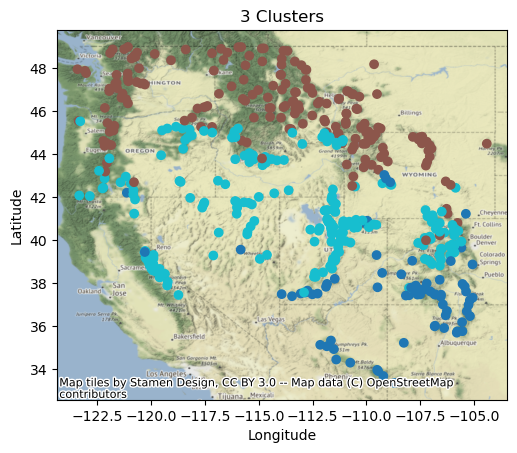

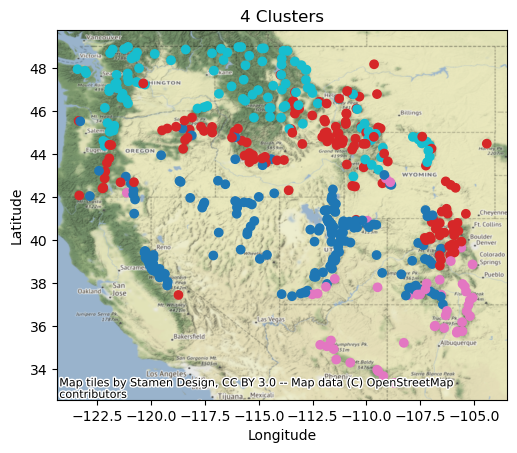

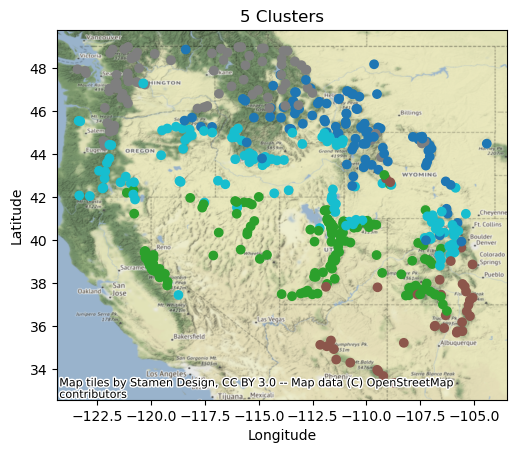

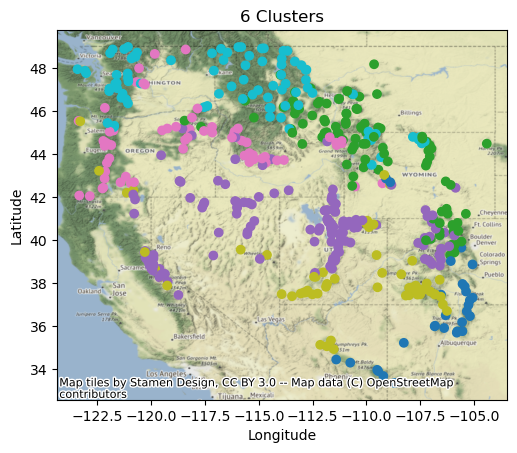

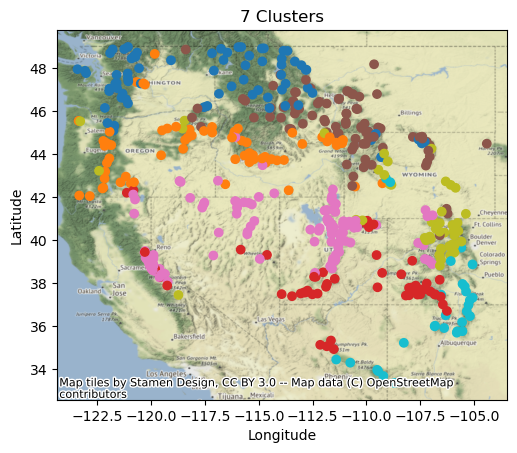

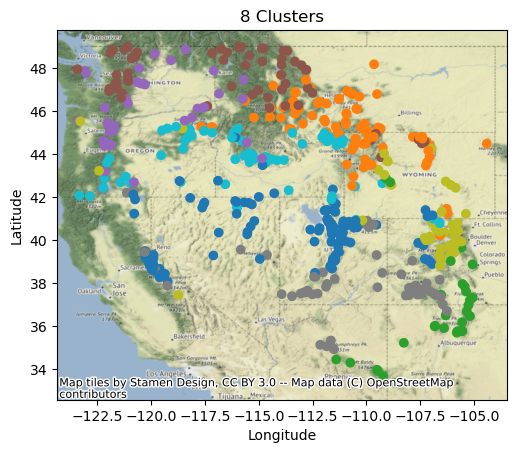

In [35]:
for i in range(3,9):
    cluster(i, pearsons_cc)

## Bring in SWE Reanalysis Data

In [20]:
import rioxarray as rxr

In [39]:
! pwd

/Users/Hannah/Documents/Documents_Grad/Research/CorrelatedDomains/notebooks


In [101]:
fn = '../data/reanalysis/2021/swe_reanalysis_2021_04_01.nc'

reanalysis = rxr.open_rasterio(fn, crs='epsg:4326')

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [102]:
print(reanalysis.dims)
print(reanalysis.attrs)
print(reanalysis.coords)

('band', 'y', 'x')
{'Latitude#Units': 'degrees_north', 'Latitude#_FillValue': nan, 'Longitude#Units': 'degrees_east', 'Longitude#_FillValue': nan, 'Units': 'meters', '_FillValue': -999.0, 'scale_factor': 1.0, 'add_offset': 0.0, 'units': 'meters'}
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 4.048e+03 4.048e+03 4.05e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 5.172e+03 5.174e+03 5.174e+03
    spatial_ref  int64 0


In [63]:
reanalysis.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    GeoTransform:  0.0 1.0 0.0 0.0 0.0 1.0

In [111]:
reanalysis = reanalysis.rio.set_spatial_dims('x','y',inplace=True)
reanalysis = reanalysis.rio.set_crs('EPSG:4326',inplace=True)

In [100]:
reanalysis

<xarray.DataArray 'SD_Post' (band: 1, y: 5175, x: 4050)>
array([[[ 0.00e+00,  0.00e+00, ...,  4.00e-04,  0.00e+00],
        [ 0.00e+00,  0.00e+00, ...,  0.00e+00,  0.00e+00],
        ...,
        [-9.99e+02, -9.99e+02, ...,  0.00e+00,  0.00e+00],
        [-9.99e+02, -9.99e+02, ..., -9.99e+02, -9.99e+02]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 4.048e+03 4.048e+03 4.05e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 5.172e+03 5.174e+03 5.174e+03
    spatial_ref  int64 0
Attributes:
    Latitude#Units:        degrees_north
    Latitude#_FillValue:   nan
    Longitude#Units:       degrees_east
    Longitude#_FillValue:  nan
    Units:                 meters
    _FillValue:            -999.0
    scale_factor:          1.0
    add_offset:            0.0
    units:                 meters

In [112]:
reanalysis_masked = reanalysis.where(reanalysis != reanalysis.attrs['_FillValue'])

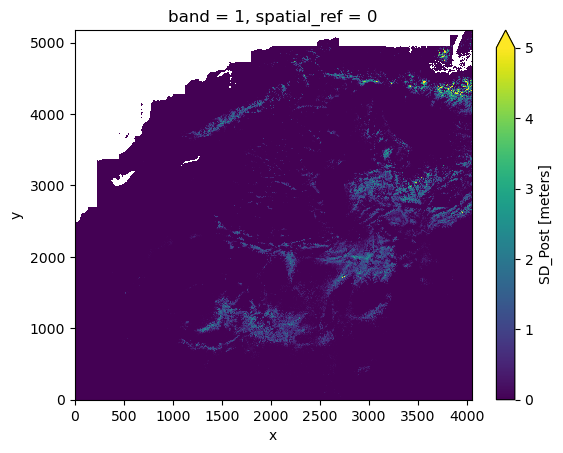

In [113]:
reanalysis_masked.squeeze().plot(vmin=0, vmax=5)

In [104]:
reanalysis.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

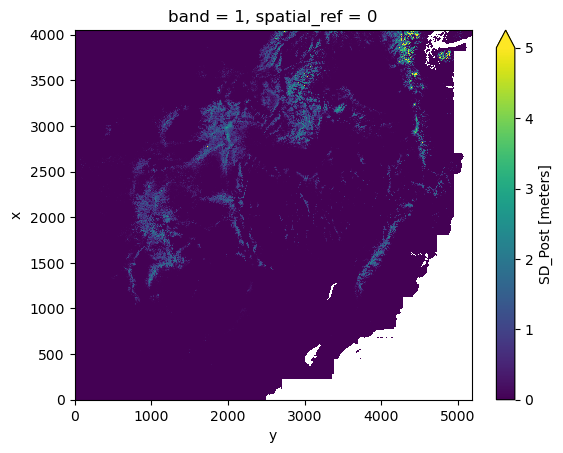

In [107]:
reanalysis_masked.T.plot(vmin=0,vmax=5)

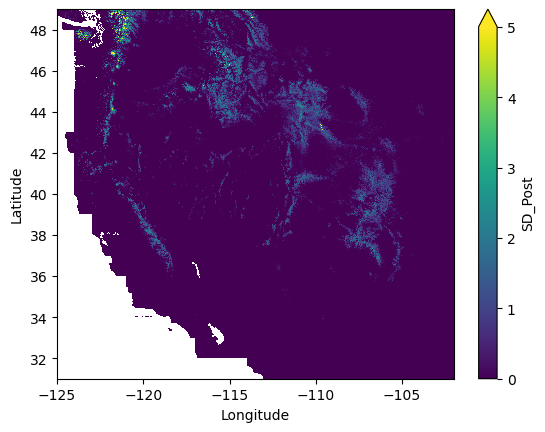

In [114]:
import xarray as xr

ds = xr.load_dataset(fn)
fig,ax = plt.subplots(dpi = 100)
ds.SD_Post.T.plot(ax=ax,vmin = 0,vmax = 5)

In [116]:
all_years = xr.open_mfdataset('../data/reanalysis/*/*.nc', concat_dim="Time", combine="nested", parallel=True)

In [117]:
all_years

<xarray.Dataset>
Dimensions:    (Latitude: 4050, Longitude: 5175, Time: 32)
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Dimensions without coordinates: Time
Data variables:
    SD_Post    (Time, Longitude, Latitude) float32 dask.array<chunksize=(1, 5175, 4050), meta=np.ndarray>

In [118]:
all_years.SD_Post.mean(dim='Time')

<xarray.DataArray 'SD_Post' (Longitude: 5175, Latitude: 4050)>
dask.array<mean_agg-aggregate, shape=(5175, 4050), dtype=float32, chunksize=(5175, 4050), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0

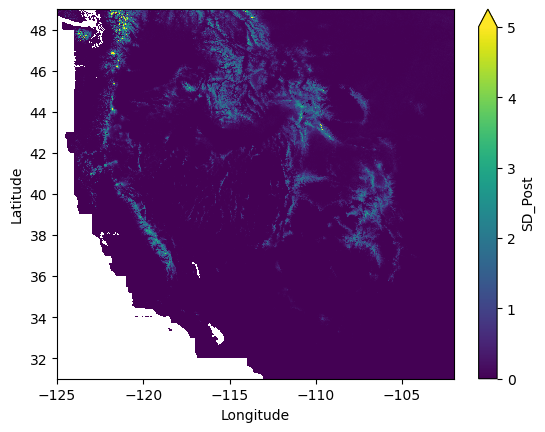

In [121]:
all_years.SD_Post.T.mean(dim='Time').plot(vmin=0,vmax=5)

In [122]:
anomalies = all_years.SD_Post - all_years.SD_Post.mean(dim='Time') 

In [161]:
anomalies1 = all_years - all_years.mean(dim='Time') 

In [167]:
anomalies1.rio.set_spatial_dims('Latitude','Longitude',inplace=True)

<xarray.Dataset>
Dimensions:    (Latitude: 4050, Longitude: 5175, Time: 32)
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Dimensions without coordinates: Time
Data variables:
    SD_Post    (Time, Longitude, Latitude) float32 dask.array<chunksize=(1, 5175, 4050), meta=np.ndarray>

In [171]:
anomalies1 = anomalies1.rio.write_crs('epsg:4326')

In [162]:
anomalies1

<xarray.Dataset>
Dimensions:    (Latitude: 4050, Longitude: 5175, Time: 32)
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Dimensions without coordinates: Time
Data variables:
    SD_Post    (Time, Longitude, Latitude) float32 dask.array<chunksize=(1, 5175, 4050), meta=np.ndarray>

In [123]:
anomalies

<xarray.DataArray 'SD_Post' (Time: 32, Longitude: 5175, Latitude: 4050)>
dask.array<sub, shape=(32, 5175, 4050), dtype=float32, chunksize=(1, 5175, 4050), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Dimensions without coordinates: Time

In [132]:
all_years.SD_Post[100:105:,100:105,100:105].values

array([], shape=(0, 5, 5), dtype=float32)

In [145]:
all_years.SD_Post[0:2,25:50,4000:].values

array([[[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
               nan],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.400e-03, 1.034e-01,
         0.000e+00],
        ...,
        [0.000e+00, 9.454e-01, 7.000e-03, ..., 0.000e+00, 0.000e+00,
         2.400e-03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         4.180e-02],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         5.180e-02]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
               nan],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.800e-03, 0.000e+00,
         0.000e+00],
        ...,
        [8.000e-04, 2.660e-02, 1.600e-03, ..., 0.000e+00, 2.200e-03,
         4.400e-02],
        [0.000e+00, 2.200e-03, 1.400e-03, ..., 0.000e+00, 2.000e-04,
   

In [147]:
anomalies[0:2,25:50,4000:].values

array([[[-2.62499991e-04,  0.00000000e+00,  0.00000000e+00, ...,
         -4.37500021e-05,  0.00000000e+00,             nan],
        [-5.56249986e-04,  0.00000000e+00,  0.00000000e+00, ...,
         -1.96631253e-01, -7.50000036e-05, -9.99999975e-05],
        [-6.24999984e-06, -1.87500009e-05,  0.00000000e+00, ...,
         -7.18812495e-02,  9.65937525e-02,  0.00000000e+00],
        ...,
        [-4.03124979e-03,  8.42949986e-01, -7.80624989e-03, ...,
         -4.37500014e-04, -1.36312498e-02, -1.26499996e-01],
        [-1.61874993e-03, -3.96250002e-03, -4.44999989e-03, ...,
         -1.28124992e-03, -3.65624987e-02, -2.21475005e-01],
        [ 0.00000000e+00, -2.56250001e-04, -5.87500050e-04, ...,
         -8.06249969e-04, -1.09749995e-02, -1.44400001e-01]],

       [[-2.62499991e-04,  0.00000000e+00,  0.00000000e+00, ...,
         -4.37500021e-05,  0.00000000e+00,             nan],
        [-5.56249986e-04,  0.00000000e+00,  0.00000000e+00, ...,
         -1.96631253e-01, -7.50000036e

In [150]:
anomalies

<xarray.DataArray 'SD_Post' (Time: 32, Longitude: 5175, Latitude: 4050)>
dask.array<sub, shape=(32, 5175, 4050), dtype=float32, chunksize=(1, 5175, 4050), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Dimensions without coordinates: Time

In [160]:
anomalies.attrs

{}

In [155]:
colorado = colorado.to_crs('epsg:4326')

In [184]:
reanalysis_col_anomalies = anomalies1.rio.clip(colorado)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape GEO_ID at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape STATE at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape NAME at index 2 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: Shape

type: No valid geometry objects found for rasterize

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='SD_Post'>

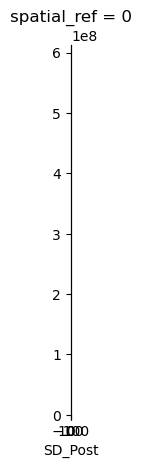

In [174]:
fig, ax = plt.subplots()
anomalies1.SD_Post.T.plot(ax=ax)
colorado.plot(ax=ax)

(array([2.60000000e+01, 1.59000000e+02, 5.17000000e+02, 1.88400000e+03,
        5.83179056e+08, 7.89800000e+03, 1.18500000e+03, 3.50000000e+02,
        5.50000000e+01, 6.00000000e+00]),
 array([-164.22541809, -129.94580078,  -95.66619873,  -61.38658905,
         -27.10697937,    7.17263031,   41.45223999,   75.73184967,
         110.01145935,  144.29107666,  178.57067871]),
 <BarContainer object of 10 artists>)

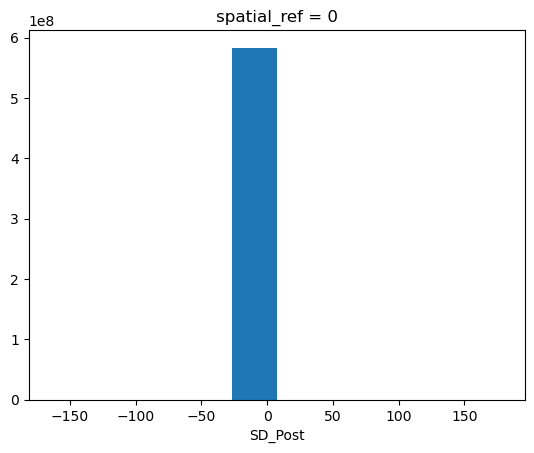

In [175]:
anomalies1.SD_Post.T.plot()

In [177]:
anomalies1.Time

<xarray.DataArray 'Time' (Time: 32)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: Time

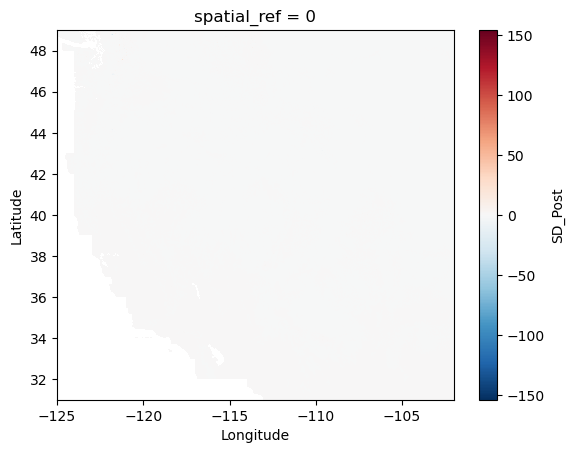

In [182]:
anomalies1.SD_Post[1:2].T.plot()

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Longitude', ylabel='Latitude'>

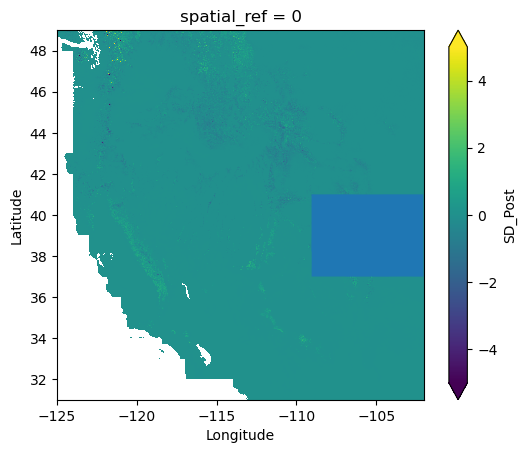

In [183]:
fig, ax = plt.subplots()
anomalies1.SD_Post[1:2].T.plot(ax=ax, vmin=-5, vmax=5)
colorado.plot(ax=ax)

In [204]:
anomalies1

<xarray.Dataset>
Dimensions:      (Latitude: 4050, Longitude: 5175, Time: 32)
Coordinates:
  * Latitude     (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude    (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0
    spatial_ref  int64 0
Dimensions without coordinates: Time
Data variables:
    SD_Post      (Time, Longitude, Latitude) float32 dask.array<chunksize=(1, 5175, 4050), meta=np.ndarray>

In [206]:
reanalysis_set_spatial = anomalies1.rio.set_spatial_dims('y','x',inplace=True)

type: x dimension (y) not found.

In [208]:
min_lon = -109.060253
min_lat = 36.992426
max_lon = -102.041524
max_lat = 41.003444

subset = reanalysis_set_spatial.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

type: No data found in bounds. Data variable: SD_Post